---
layout: single
title: 'Calculating slope and aspect from a digital elevation model in Python'
date: 2016-07-26
authors: [Matt Oakley, Max Joseph]
category: [tutorials]
excerpt: 'This tutorial shows how to compute the slope and aspect from a digital elevation model in Python.'
sidebar:
  nav:
author_profile: false
comments: true
lang: [python]
lib: [matplotlib, numpy, elevation, pydem]
---

Digital elevation models (DEM) provide a representaion of surface topography (elevation) in two dimensional space. DEMs are a 3D representaion of a terrain's surface such as the Earth. Typically, DEM data can be represented as a raster which is most easily expressed as being a 2D array with each individual cell having an elevation associated with it. 

With this data, we are able to use programs in order to analyze certain physical aspects about the area associated with the data. This tutorial will go over how we compute the **slope** and **aspect** of an area using DEM data.

## Objectives

- Read in DEM data
- Compute the slope for the entirety of the data
- Compute the aspect for the entirety of the data
- Output a PNG image visualizing the slope of the terrain
- Output a PNG image visualizing the aspect of the terrain

## Dependencies

- NumPy
- matplotlib
- elevation
- pyDEM

Note that as of 2016-12-14, this tutorial uses a custom installation of pyDEM, which can be installed directly from GitHub from the command line via 

```
pip install git+git://github.com/mbjoseph/pydem.git
```

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import elevation
from pydem.dem_processing import DEMProcessor
from matplotlib.colors import ListedColormap
from matplotlib import colors

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

## Download a digital elevation model

Our first objective is acquire a DEM. We'll do this with the `elevation` module, which allows you to fetch data from the NASA SRTM mission via a bounding box. Here we draw a bounding box around Mt. Shasta in northern California, and use the command line interface to output a GeoTIFF. 

In [2]:
!eio clip -o Shasta-30m-DEM.tif --bounds -122.4 41.2 -122.1 41.5 

Your system is ready.
make: Nothing to be done for `download'.
make: Nothing to be done for `all'.
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin -122.4 41.5 -122.1 41.2 SRTM1.vrt /Users/majo3748/Documents/earthlab/tutorials/python/Shasta-30m-DEM.tif


Use the DEMProcessor to compute slope and aspect for the DEM: 

In [3]:
# needs to match above command
filename = 'Shasta-30m-DEM.tif'

# instantiate a processor object
processor = DEMProcessor(filename)

# get magnitude of slope and aspect
mag, aspect = processor.calc_slopes_directions()

/Users/majo3748/anaconda/envs/py27/lib/python2.7/site-packages/pydem/dem_processing.py:563: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  self.data[data.mask] = FILL_VALUE


starting slope/direction calculation for chunk 1 [0:516, 0:516]
starting slope/direction calculation for chunk 2 [0:516, 508:1028]
starting slope/direction calculation for chunk 3 [0:516, 1020:1080]
starting slope/direction calculation for chunk 4 [508:1028, 0:516]
starting slope/direction calculation for chunk 5 [508:1028, 508:1028]
starting slope/direction calculation for chunk 6 [508:1028, 1020:1080]
starting slope/direction calculation for chunk 7 [1020:1080, 0:516]
starting slope/direction calculation for chunk 8 [1020:1080, 508:1028]
starting slope/direction calculation for chunk 9 [1020:1080, 1020:1080]


Let's peek at these objects, both of which are numeric arrays. 

In [4]:
mag

array([[        nan,         nan,         nan, ...,  0.32364485,
         0.44950795,  0.2586934 ],
       [        nan,         nan,         nan, ...,  0.32364485,
         0.44950795,  0.41471453],
       [        nan,         nan,  0.04311538, ...,  0.43404787,
         0.4197514 ,  0.28500046],
       ..., 
       [ 0.44798625,  0.44798625,  0.51895544, ...,  0.1062964 ,
         0.12971104,  0.12971104],
       [ 0.3983211 ,  0.47653369,  0.52412218, ...,  0.07775003,
         0.10756881,  0.1297108 ],
       [ 0.42918458,  0.5150215 ,  0.55793996, ...,  0.07775003,
         0.10756881,  0.08583692]])

In [5]:
aspect

array([[        nan,         nan,         nan, ...,  2.49694673,
         2.6124799 ,  3.14159265],
       [        nan,         nan,         nan, ...,  2.49694673,
         2.6124799 ,  2.24437453],
       [        nan,         nan,  3.14159265, ...,  2.67698894,
         2.37318076,  2.22072197],
       ..., 
       [ 0.53113069,  0.53113069,  0.59700458, ...,  4.29676177,
         3.98922813,  3.98922813],
       [ 0.2466342 ,  6.14671481,  6.09656191, ...,  4.12762132,
         3.78846596,  3.98923025],
       [ 0.        ,  0.        ,  0.        , ...,  4.12762132,
         3.78846596,  3.14159265]])

Next, let's visualize aspect and slope using the `imshow` function. 

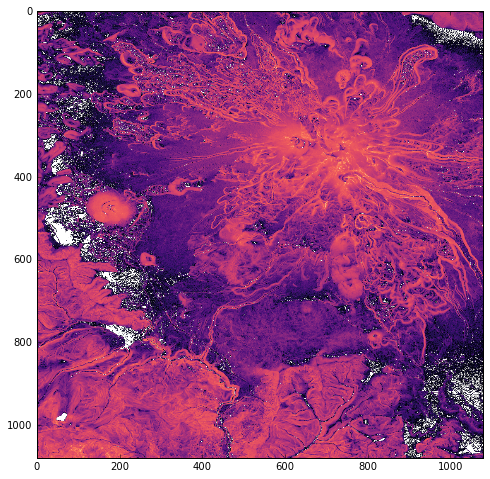

In [6]:
# use a log scale to normalize the scale a bit
plt.imshow(np.log(mag), cmap="magma")

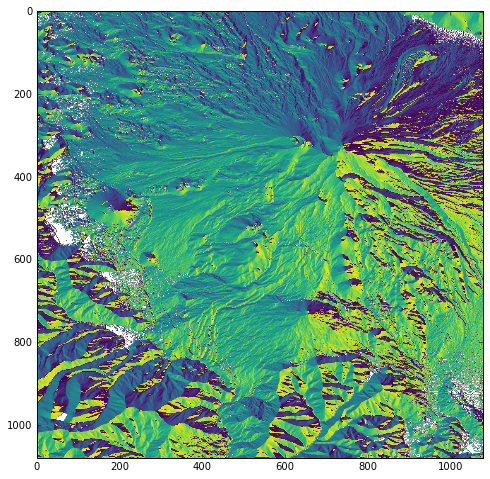

In [7]:
plt.imshow(aspect, cmap = "viridis")